In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN, HDBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_hdbscan_deltaMC_dr01.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_hdbscan_gun_deltamc.pt"
sd_hgb2, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_hdbscan_drlog_v9_99500_oclustering_gun_05_130225_400_2020.pt" #0_0_None_hdbscan_drlog_v9_99500_oclustering_gun_05_130225_400_2020, 0_0_None_hdbscan_gun_drlog_v9_99500_hdbscan_gun_05_130225_400
sd_hgb3, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_pandora_gun_drlog_v9_99500_hdbscan_gun_05_130225_400.pt"
sd_pandora, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

In [4]:
nan_pandora= sd_pandora[(sd_pandora["true_showers_E"]>10)*(np.isnan(sd_pandora["pred_showers_E"]))]
pid_values = np.abs(nan_pandora.pid.values)
is_track_in_MC = nan_pandora.is_track_in_MC.values
for i in np.unique(pid_values):
    print(i, np.sum(pid_values==i), np.sum((pid_values==i)*(is_track_in_MC)))

11.0 15 3
22.0 32 0
130.0 17 0
211.0 5 0
321.0 2 2
2112.0 38 0
2212.0 3 3


In [16]:
sd_hgb3[(sd_hgb3["true_showers_E"]>10)*(np.isnan(sd_hgb3["pred_showers_E"]))]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,...,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,pred_pos_matched,pred_pid_matched,pred_ref_pt_matched,matched_extra_features,true_pos,pid_4_class_true
2,34.307388,34.004169,NaN,NaN,-2212.0,NaN,NaN,5.0,54.0,0.0,...,NaN,352.0,319.0,0.100818,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[21.876012802124023, -26.313142776489258, -2.2...",1.0
14,33.480492,37.483955,NaN,NaN,2212.0,NaN,NaN,6.0,64.0,0.0,...,NaN,43.0,346.0,0.018470,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-30.338970184326172, 13.875694274902344, -2.6...",1.0
12,17.722698,22.480997,NaN,NaN,-321.0,NaN,NaN,8.0,83.0,0.0,...,NaN,536.0,55.0,0.036657,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[17.218482971191406, 3.1830878257751465, 2.691...",1.0
4,22.414782,18.677990,NaN,NaN,211.0,NaN,NaN,13.0,138.0,0.0,...,NaN,44.0,149.0,0.026942,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-18.7170467376709, 12.131537437438965, 2.2138...",1.0
1,23.295952,19.343582,NaN,NaN,-2112.0,NaN,NaN,15.0,156.0,0.0,...,NaN,4.0,224.0,0.013240,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[4.475785732269287, 20.800222396850586, 9.4412...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,11.508252,8.152837,NaN,NaN,2112.0,NaN,NaN,390.0,3904.0,0.0,...,NaN,2.0,108.0,0.027223,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[11.13626480102539, -2.736013650894165, -0.234...",2.0
10,10.594535,10.258571,NaN,NaN,-321.0,NaN,NaN,393.0,3938.0,0.0,...,NaN,299.0,59.0,0.014575,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-1.5937190055847168, -10.458477020263672, -0....",1.0
31,11.424533,8.258866,NaN,NaN,22.0,NaN,NaN,393.0,3938.0,0.0,...,NaN,322.0,1.0,0.012919,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-1.9655554294586182, -11.005913734436035, 2.3...",3.0
11,10.715695,6.346294,NaN,NaN,22.0,NaN,NaN,394.0,3946.0,0.0,...,NaN,223.0,1.0,0.011127,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-7.744639873504639, 6.896845817565918, 2.6981...",3.0


In [17]:
nan_pandora= sd_hgb3[(sd_hgb3["true_showers_E"]>10)*(np.isnan(sd_hgb3["pred_showers_E"]))]
pid_values = np.abs(nan_pandora.pid.values)
is_track_in_MC = nan_pandora.is_track_in_MC.values
for i in np.unique(pid_values):
    print(i, np.sum(pid_values==i), np.sum((pid_values==i)*(is_track_in_MC)))

# 11.0 31 16
# 13.0 17 17
# 22.0 49 0
# 130.0 30 0
# 211.0 33 26
# 321.0 22 20
# 2112.0 68 0
# 2212.0 23 23

11.0 22 10
13.0 10 10
22.0 35 0
130.0 14 0
211.0 13 10
321.0 10 8
2112.0 34 0
2212.0 10 10


In [6]:
sd_hgb3.keys()

Index(['true_showers_E', 'reco_showers_E', 'pred_showers_E',
       'e_pred_and_truth', 'pid', 'calibration_factor', 'calibrated_E', 'step',
       'number_batch', 'is_track_in_cluster', 'is_track_correct',
       'is_track_in_MC', 'distance_to_cluster_MC', 'vertex', 'ECAL_hits',
       'HCAL_hits', 'ECAL_hits_true', 'HCAL_hits_true', 'delta_MC',
       'pred_pos_matched', 'pred_pid_matched', 'pred_ref_pt_matched',
       'matched_extra_features', 'true_pos', 'pid_4_class_true'],
      dtype='object')

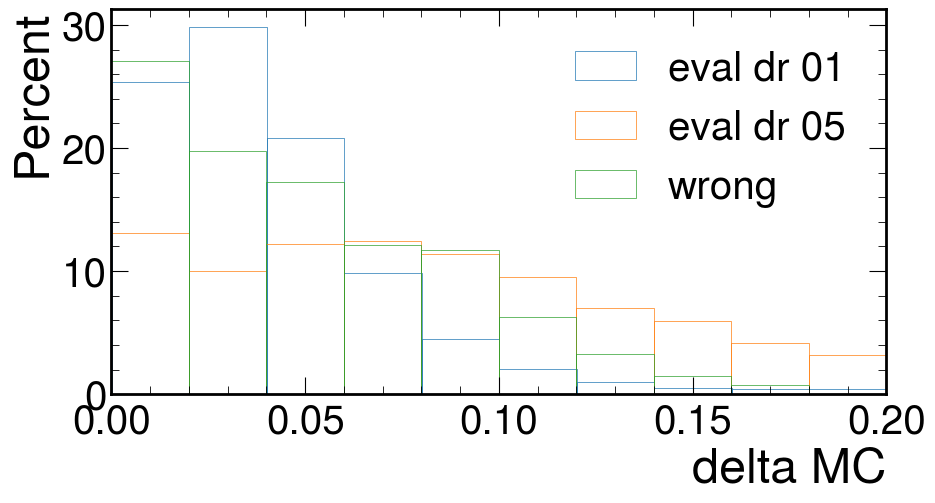

In [13]:
import seaborn as sns
plt.figure(figsize=(10,5))
nan_delta = sd_hgb3[(sd_hgb3["true_showers_E"]>10)*(np.isnan(sd_hgb3["pred_showers_E"]))]
# bins = np.logspace(np.log10(min(sd_hgb["delta_MC"].values+1e-4)), np.log10(max(sd_hgb["delta_MC"].values)), 30)
# bins = np.arange(min(sd_hgb["delta_MC"].values+1e-4), max(sd_hgb["delta_MC"].values), 30)
sns.histplot(sd_hgb["delta_MC"].values, binwidth=0.02, stat="percent",label="eval dr 01", fill=False)
sns.histplot(sd_hgb2["delta_MC"].values, binwidth=0.02,  stat="percent",label="eval dr 05", fill=False)
sns.histplot(nan_delta["delta_MC"].values, binwidth=0.02,  stat="percent",label="wrong", fill=False)
# plt.xscale('log') 
plt.xlabel("delta MC")
plt.xlim([0,0.2])
plt.legend()

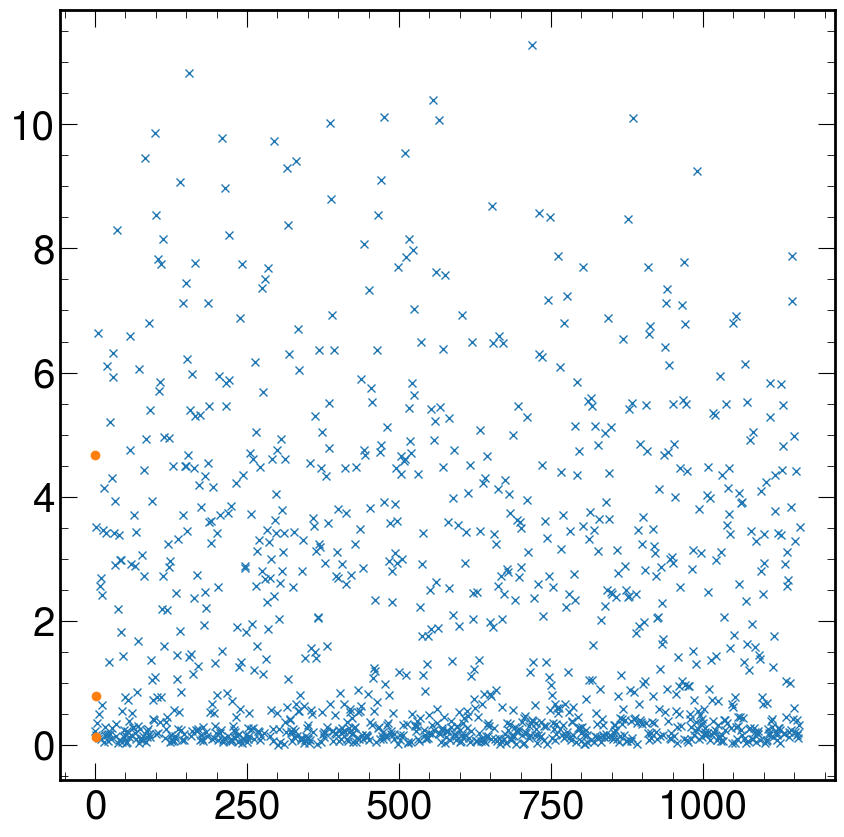

In [8]:
plt.plot(sd_hgb[(sd_hgb["true_showers_E"]>10)*(np.abs(sd_hgb["pid"])==211)]["HCAL_hits_true"].values/ sd_hgb[(sd_hgb["true_showers_E"]>10)*(np.abs(sd_hgb["pid"])==211)]["ECAL_hits_true"].values,'x')
plt.plot(sd_hgb[(sd_hgb["true_showers_E"]>10)*(np.abs(sd_hgb["pid"])==211)*(np.isnan(sd_hgb["pred_showers_E"]))]["HCAL_hits_true"].values/ sd_hgb[(sd_hgb["true_showers_E"]>10)*(np.abs(sd_hgb["pid"])==211)*(np.isnan(sd_hgb["pred_showers_E"]))]["ECAL_hits_true"].values,'o')

In [9]:
sd_pandora[(sd_pandora["true_showers_E"]>10)*(np.abs(sd_pandora["pid"])==211)*(np.isnan(sd_pandora["pred_showers_E"]))]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,...,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,true_pos,pid_4_class_true
13,10.112937,10.159225,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",-211.0,NaN,...,0,0.0,"[378.61456298828125, -854.87109375, 367.119537...",NaN,NaN,49.0,101.0,0.050042,"[4.588817119598389, -8.189399719238281, 3.7587...",1.0
11,13.288325,14.664300,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",211.0,NaN,...,0,0.0,"[-1555.5078125, -220.91529846191406, 177.68647...",NaN,NaN,154.0,95.0,0.017871,"[-13.140216827392578, -1.5050020217895508, 1.2...",1.0
13,11.665924,12.641893,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",-211.0,NaN,...,0,0.0,"[-1131.646484375, 406.73077392578125, -580.024...",NaN,NaN,134.0,106.0,0.007752,"[-9.899717330932617, 3.5082321166992188, -5.07...",1.0
10,17.454470,23.282207,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",-211.0,NaN,...,0,0.0,"[-137.60556030273438, 711.0167846679688, 175.1...",NaN,NaN,256.0,154.0,0.019425,"[-3.2356090545654297, 16.607688903808594, 4.28...",1.0
14,12.401534,13.875722,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",211.0,NaN,...,0,0.0,"[-512.3909301757812, -436.176513671875, -373.8...",NaN,NaN,43.0,130.0,0.012665,"[-8.412741661071777, -6.678917407989502, -6.19...",1.0


In [10]:
sd_hgb[(sd_hgb["true_showers_E"]>10)*(np.abs(sd_hgb["pid"])==211)*(np.isnan(sd_hgb["pred_showers_E"]))]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,...,HCAL_hits,ECAL_hits_true,HCAL_hits_true,delta_MC,pred_pos_matched,pred_pid_matched,pred_ref_pt_matched,matched_extra_features,true_pos,pid_4_class_true
12,17.467365,21.948503,NaN,NaN,-211.0,NaN,NaN,49.0,495.0,0.0,...,NaN,40.0,187.0,0.008983,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[14.778584480285645, -8.370357513427734, -4.07...",1.0
2,16.561714,15.549034,NaN,NaN,-211.0,NaN,NaN,76.0,765.0,0.0,...,NaN,549.0,67.0,0.223142,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[13.358470916748047, 5.226413249969482, -8.276...",1.0
13,11.665924,12.641892,NaN,NaN,-211.0,NaN,NaN,224.0,2241.0,0.0,...,NaN,134.0,106.0,0.007752,"[nan, nan, nan]",NaN,"[nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan]","[-9.899717330932617, 3.5082321166992188, -5.07...",1.0


In [11]:
400*10

4000